In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install skforecast

## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent. However, we want to predict all variables therefore therefore, we are going build a model that can handle parallel multiseries data

> Parallel multiseries forcasting can be:
 * ***Dependent*** multi-series => using *ForecasterAutoregMultiSeries* and *ForecasterAutoregMultiSeriesCustom* classes
 * ***Independent*** multiseries => using  *ForecasterAutoregMultiVariate* class

## Independent

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df_downsampled = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_MODISData.csv')
df_downsampled = df_downsampled[['date','ndvi','evi','ndwi']]
df_downsampled.head()

,date,ndvi,evi,ndwi
0,2000-03-23,0.194392,0.131728,-0.066057
1,2000-03-30,0.188009,0.121651,-0.059209
2,2000-04-06,0.180129,0.124651,-0.051936
3,2000-04-13,0.167050,0.131804,-0.032578
4,2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Data preparation
data = df_downsampled
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,ndvi,evi,ndwi
date,,,
2000-03-23,0.194392,0.131728,-0.066057
2000-03-30,0.188009,0.121651,-0.059209
2000-04-06,0.180129,0.124651,-0.051936
2000-04-13,0.167050,0.131804,-0.032578
2000-04-20,0.147221,0.137204,-0.013235


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2000-03-23 00:00:00 --- 2019-12-26 00:00:00   (n=1032)
Test dates  : 2020-01-02 00:00:00 --- 2023-02-16 00:00:00   (n=164)


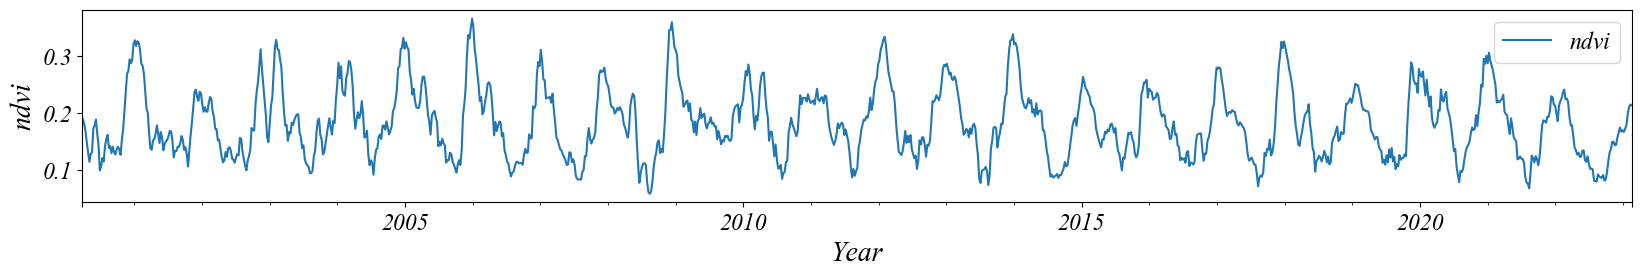

In [ ]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Times New Roman'
# Plot
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data['ndvi'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

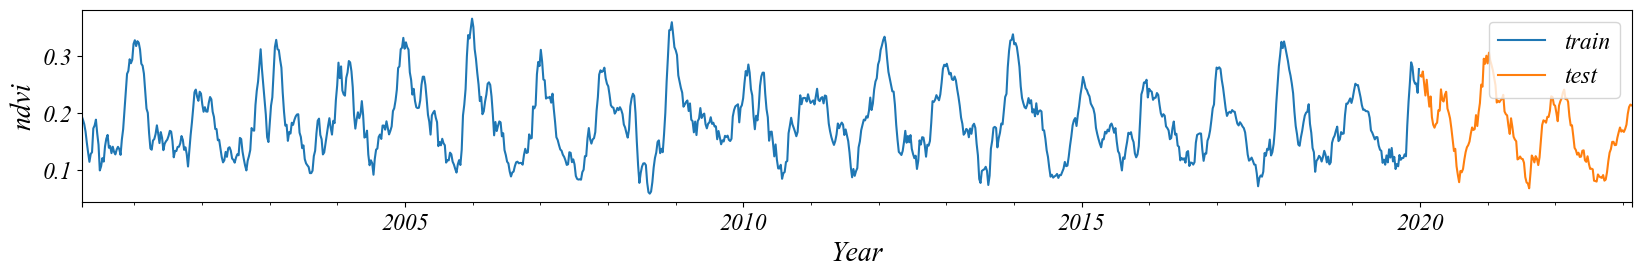

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

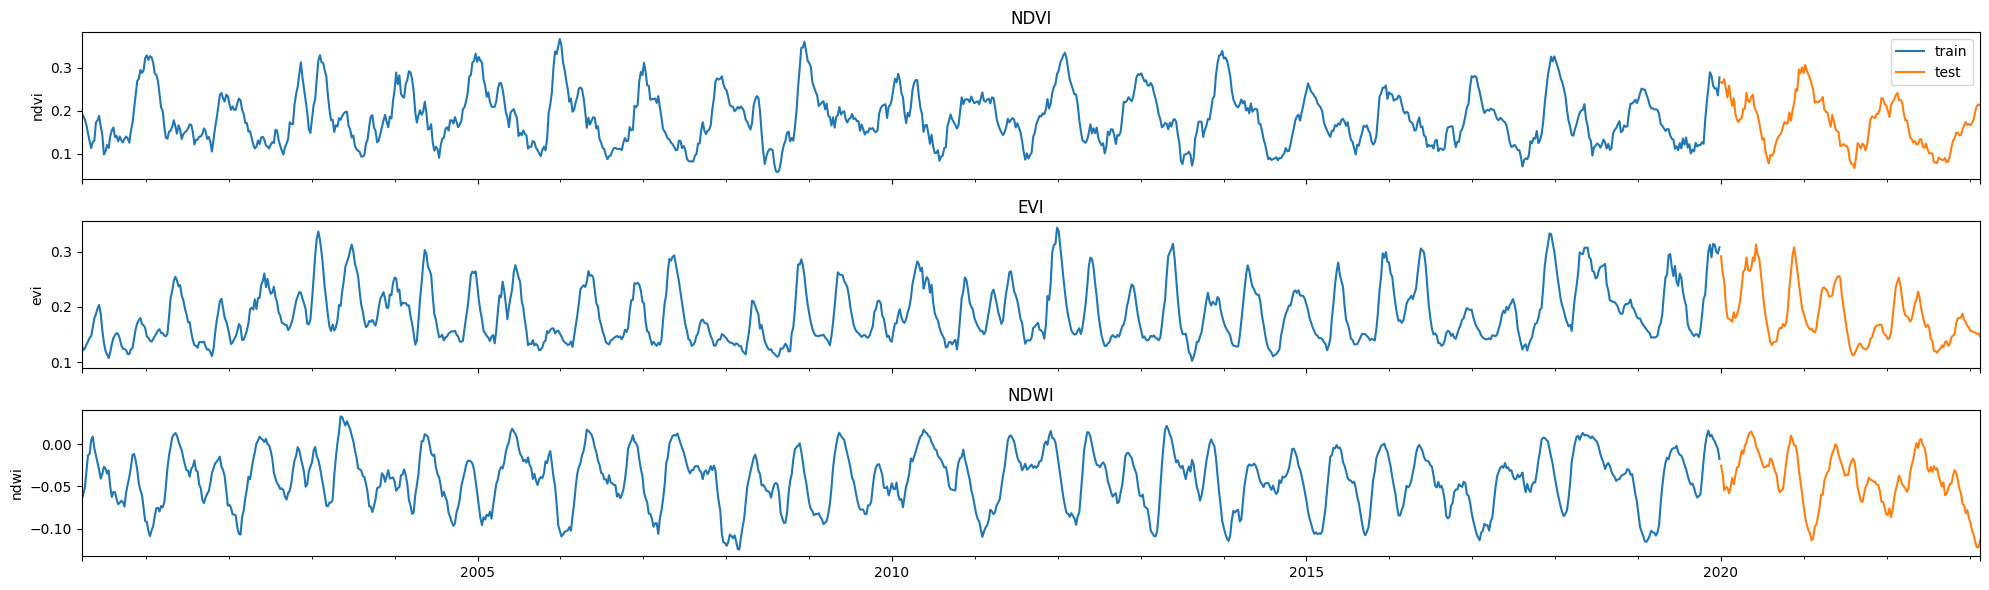

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 6), sharex=True)

data_train['ndvi'].plot(label='train', ax=axes[0])
data_test['ndvi'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('ndvi')
axes[0].set_title('NDVI')
axes[0].legend()

data_train['evi'].plot(label='train', ax=axes[1])
data_test['evi'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('evi')
axes[1].set_title('EVI')

data_train['ndwi'].plot(label='train', ax=axes[2])
data_test['ndwi'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('ndwi')
axes[2].set_title('NDWI')

fig.tight_layout()
plt.show();

### XGBoost

> Single-Step

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = XGBRegressor(),
                 lags               = 20,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [10,20,50,100]
param_distributions = {
    'n_estimators': [50,100,200],
    'max_depth': [5, 10, 15]
}
levels = ['ndvi', 'evi', 'ndwi']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_distributions,
              steps               = 1,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

36 models compared for 3 level(s). Number of iterations: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,max_depth,n_estimators
0,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.008824,5,50
9,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.008927,5,50
18,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.008999,5,50
11,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.009044,5,200
1,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.009050,5,100
10,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.009068,5,100
2,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 200}",0.009117,5,200
19,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.009135,5,100
20,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.009160,5,200
13,"[ndvi, evi, ndwi]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.009345,10,100


In [ ]:
print(results.lags[0])

[ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
# Create Forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = XGBRegressor(max_depth= 5, n_estimators=50),
                 lags               = 10,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )
forecaster.fit(data)

In [ ]:

# Backtesting Multi Series
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = None,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/164 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,ndvi,0.011387,0.000221,0.073804
1,evi,0.008149,0.000117,0.043706
2,ndwi,0.005359,0.000044,0.588235



Backtest predictions


,ndvi,evi,ndwi
2020-01-02,0.288426,0.291911,-0.026521
2020-01-09,0.262002,0.270028,-0.034402
2020-01-16,0.252404,0.252766,-0.043153
2020-01-23,0.266840,0.233891,-0.059985


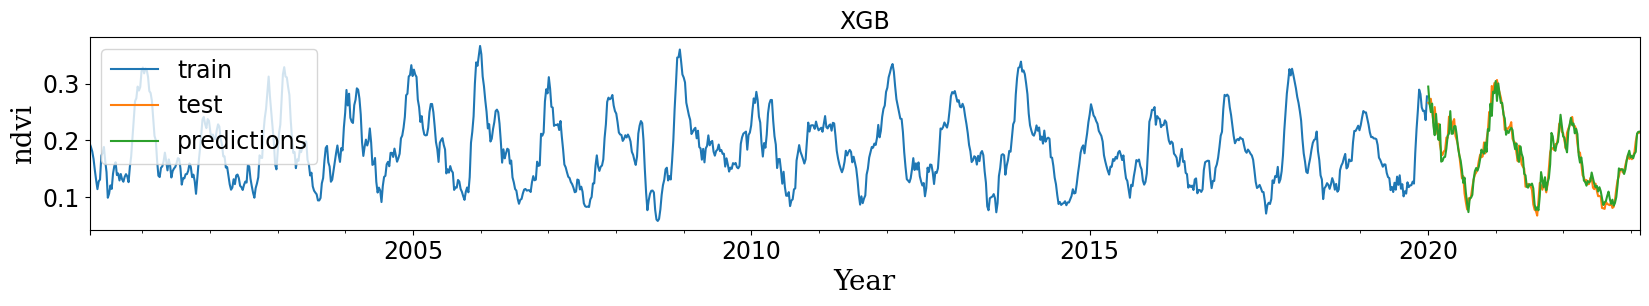

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndvi'].plot(ax=ax, label='train')
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='XGB')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

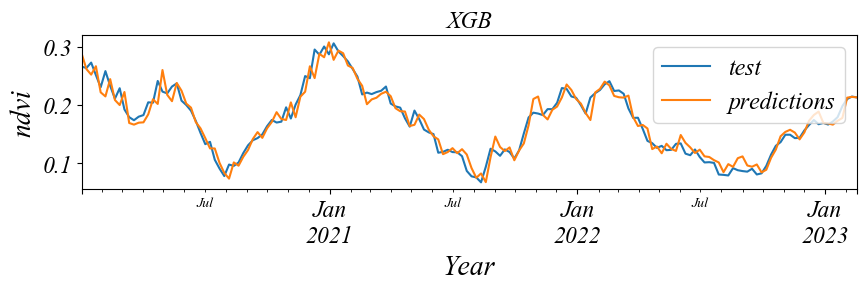

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndvi'].plot(ax=ax, label='test')
backtest_predictions['ndvi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='XGB')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndvi",fontdict = font2)
ax.legend(fontsize=17);

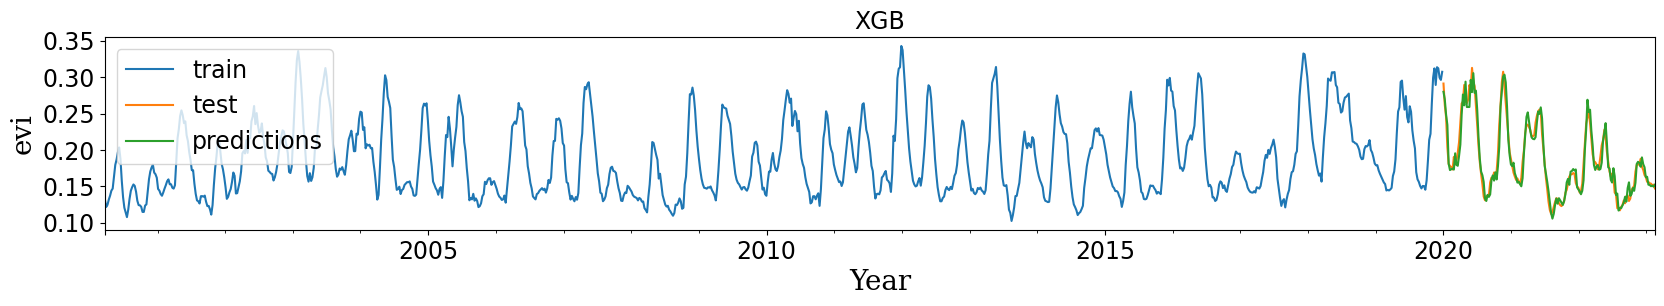

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['evi'].plot(ax=ax, label='train')
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='XGB')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

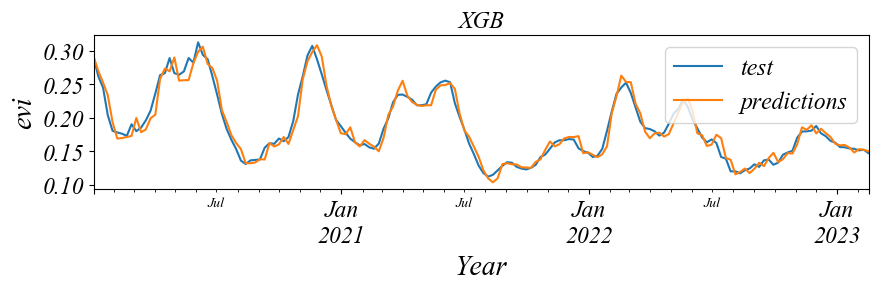

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['evi'].plot(ax=ax, label='test')
backtest_predictions['evi'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='XGB')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("evi",fontdict = font2)
ax.legend(fontsize=17);

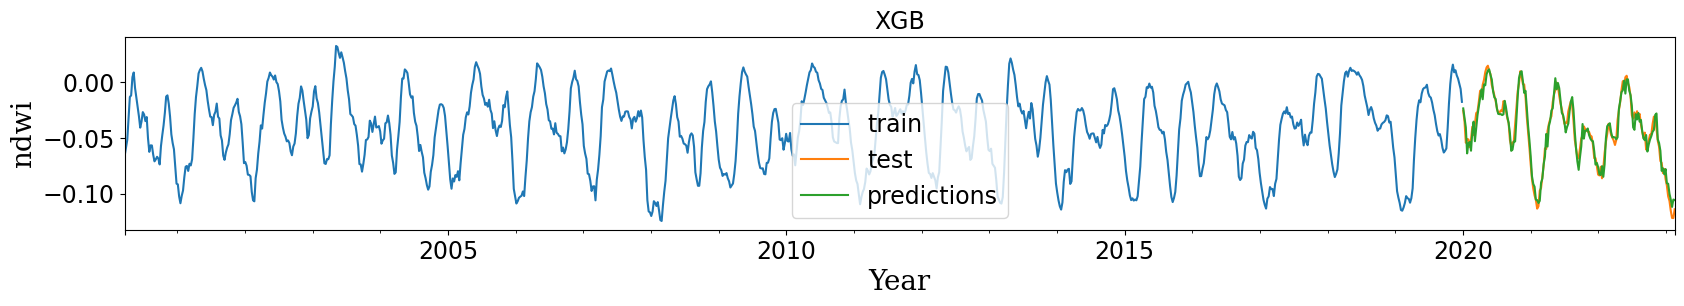

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['ndwi'].plot(ax=ax, label='train')
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='XGB')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

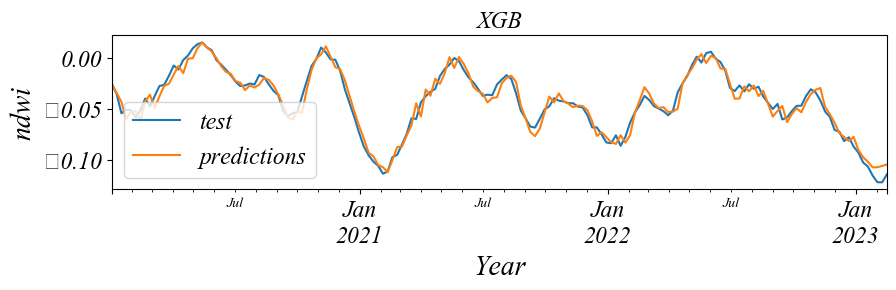

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['ndwi'].plot(ax=ax, label='test')
backtest_predictions['ndwi'].plot(ax=ax, label='predictions')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.title(fontsize=17,label='XGB')
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("ndwi",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndvi'],backtest_predictions['ndvi'])
mse = mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi'])
r2 = r2_score(data_test['ndvi'],backtest_predictions['ndvi'])
rmse = math.sqrt(mean_squared_error(data_test['ndvi'],backtest_predictions['ndvi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.011645307865968874
MSE is 0.00022432856363568737
RMSE is 0.01497760206560741
R2 is 0.932231873871553


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['evi'],backtest_predictions['evi'])
mse = mean_squared_error(data_test['evi'],backtest_predictions['evi'])
r2 = r2_score(data_test['evi'],backtest_predictions['evi'])
rmse = math.sqrt(mean_squared_error(data_test['evi'],backtest_predictions['evi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.00918710371370754
MSE is 0.000144196356258815
RMSE is 0.012008178723637278
R2 is 0.9394641943889812


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['ndwi'],backtest_predictions['ndwi'])
mse = mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi'])
r2 = r2_score(data_test['ndwi'],backtest_predictions['ndwi'])
rmse = math.sqrt(mean_squared_error(data_test['ndwi'],backtest_predictions['ndwi']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.005640810248499311
MSE is 4.844271894131832e-05
RMSE is 0.006960080383251211
R2 is 0.9490593116838703


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.008824407276058575
MSE is 0.00013898921294527356
RMSE is 0.011789368640655596
R2 is 0.9402517933148015


In [ ]:
forecaster.fit(data)

In [ ]:
future_prediction=forecaster.predict(steps=300)

In [ ]:
future_prediction

,ndvi,evi,ndwi
2023-02-23,0.207080,0.146217,-0.103622
2023-03-02,0.200271,0.148464,-0.101030
2023-03-09,0.185563,0.148464,-0.097317
2023-03-16,0.183755,0.149471,-0.094762
2023-03-23,0.192603,0.151058,-0.093178
...,...,...,...
2028-10-19,0.149084,0.181263,-0.048281
2028-10-26,0.153005,0.181084,-0.040794
2028-11-02,0.150018,0.175541,-0.031314
2028-11-09,0.149084,0.174364,-0.027073


Text(0, 0.5, 'NDVI')

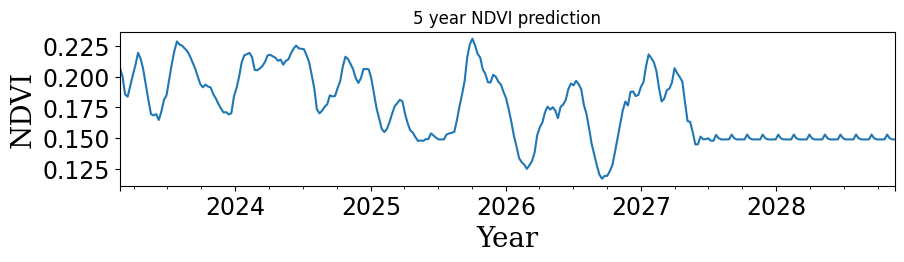

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['ndvi'].plot(ax=ax, label='ndvi',title='5 year NDVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDVI",fontdict = font2)

Text(0, 0.5, 'EVI')

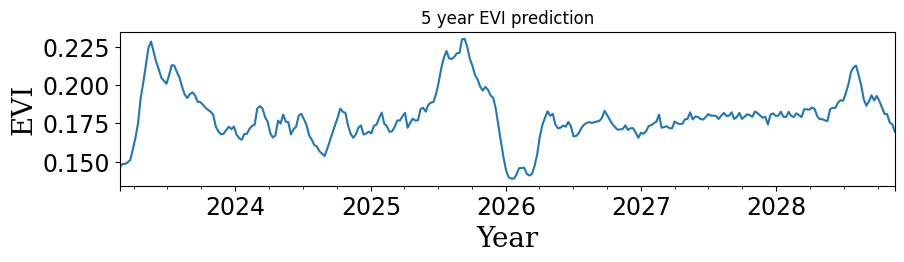

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['evi'].plot(ax=ax, label='evi',title='5 year EVI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("EVI",fontdict = font2)

Text(0, 0.5, 'NDWI')

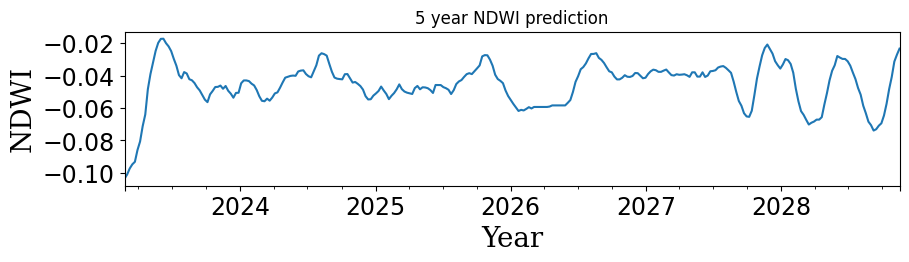

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
future_prediction['ndwi'].plot(ax=ax, label='ndwi',title='5 year NDWI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("NDWI",fontdict = font2)